In [1]:
import pandas as pd
import numpy as np
import re
import plotly.express as px
import plotly.graph_objects as go
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
import cv2
from deepface import DeepFace
import os
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from data import *
from mtcnn import MTCNN
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms,models
from PIL import Image
from transformers import GPT2LMHeadModel,GPT2Tokenizer
from PIL import Image,ImageDraw,ImageFont

In [42]:
image_path=[f for f in os.listdir(os.getcwd()) if f.endswith('jpeg')][1]

background_path=[f for f in os.listdir(os.getcwd()) if f.endswith('webp')][0]

In [ ]:
# You can add overlay or text here based on face detection results
cv2.imshow('Detected Face', image)
cv2.waitKey(1)
cv2.destroyAllWindows()

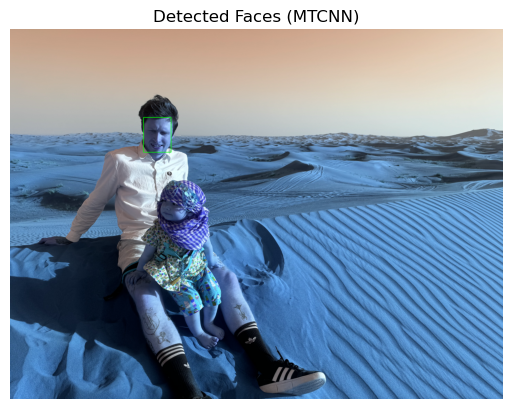

In [44]:
faces,image=detect_faces(image_path)

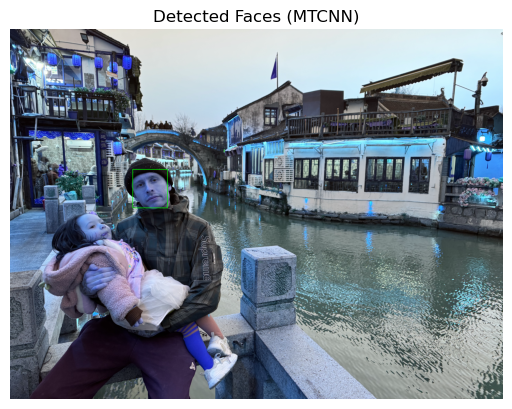

In [14]:
faces,image=detect_faces(image_path)

In [28]:
emotion=analyze_mood(image)

Detected emotion: happy


In [208]:
vgg=models.vgg19(pretrained=True).features

In [54]:

# Load pre-trained VGG19 model for style transfer
def load_vgg19():
    vgg = models.vgg19(pretrained=True).features
    for param in vgg.parameters():
        param.requires_grad_(False)  # Freeze parameters
    return vgg

# Define content and style layers
content_layers = ['14']  # conv3_2
style_layers = ['0', '5', '10','19','28']  # Fewer style layers for balance

# Image transformation pipeline
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for VGG19
])

# Extract features from the image using VGG19
def get_features(image, model, layers):
    features = {}
    x = image
    for name, layer in enumerate(model):
        x = layer(x)
        if str(name) in layers:
            features[str(name)] = x
    return features

# Calculate Gram matrix for style loss
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram / (d * h * w)  # Normalize to prevent huge values

# Perform neural style transfer
def style_transfer(content_path, style_path, output_path, iterations=200, content_weight=1, style_weight=1e6):
    # Load and preprocess images
    content = transform(Image.open(content_path)).unsqueeze(0)
    style = transform(Image.open(style_path)).unsqueeze(0)
    
    # Move to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    content = content.to(device)
    style = style.to(device)
    
    # Initialize the output image
    output = content.clone().requires_grad_(True)
    
    # Load VGG19 model and move to GPU
    vgg = load_vgg19().to(device)
    
    # Define the optimizer (changed from LBFGS to Adam for better stability)
    optimizer = optim.Adam([output], lr=0.003)  # Lower learning rate for stability
    
    # Extract content and style features
    content_features = get_features(content, vgg, content_layers)
    style_features = get_features(style, vgg, style_layers)
    
    # Calculate style Gram matrices
    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
    
    # Run style transfer
    for i in range(iterations):
        optimizer.zero_grad()
        
        # Get output features
        output_features = get_features(output, vgg, content_layers + style_layers)
        
        # Calculate content loss
        content_loss = 0
        for layer in content_layers:
            content_loss += torch.mean((output_features[layer] - content_features[layer]) ** 2)
        content_loss *= content_weight
        
        # Calculate style loss
        style_loss = 0
        for layer in style_layers:
            output_gram = gram_matrix(output_features[layer])
            style_gram = style_grams[layer]
            style_loss += torch.mean((output_gram - style_gram) ** 2)
        style_loss *= style_weight
        
        # Total loss
        loss = content_loss + style_loss
        loss.backward()
        optimizer.step()
        
        # Print progress every 50 iterations
        if i % 50 == 0:
            print(f"Iteration {i}/{iterations} - Content Loss: {content_loss.item()} - Style Loss: {style_loss.item()}")

    # Save the output image
    output = output.squeeze(0).cpu().detach()
    output = transforms.Normalize(mean=[-2.12, -2.04, -1.80], std=[4.37, 4.46, 4.44])(output)  # Denormalize
    output_image = transforms.ToPILImage()(output)
    output_image.save(output_path)

    # Display the stylized image
    plt.imshow(output_image)
    plt.axis('off')
    plt.show()


In [ ]:
#1e-1

Iteration 0/500 - Content Loss: 0.0 - Style Loss: 205.7720489501953
Iteration 50/500 - Content Loss: 6.029651165008545 - Style Loss: 27.813995361328125
Iteration 100/500 - Content Loss: 6.542037010192871 - Style Loss: 15.196342468261719
Iteration 150/500 - Content Loss: 6.458860874176025 - Style Loss: 11.337749481201172
Iteration 200/500 - Content Loss: 6.329527378082275 - Style Loss: 9.310511589050293
Iteration 250/500 - Content Loss: 6.199552536010742 - Style Loss: 8.007424354553223
Iteration 300/500 - Content Loss: 6.08327579498291 - Style Loss: 7.06950044631958
Iteration 350/500 - Content Loss: 5.973917007446289 - Style Loss: 6.361380577087402
Iteration 400/500 - Content Loss: 5.876424312591553 - Style Loss: 5.806031703948975
Iteration 450/500 - Content Loss: 5.793460369110107 - Style Loss: 5.351478576660156


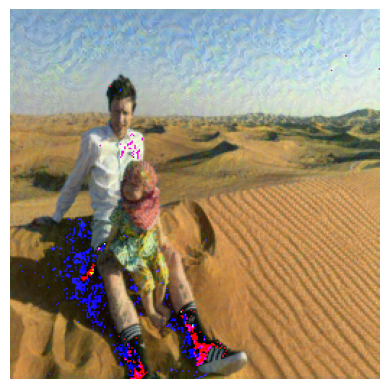

In [56]:
# Test style transfer
content_path = image_path  # Replace with your content image path
style_path = background_path  # Replace with your style image path
output_path = "styled_image.jpg"
style_transfer(content_path, style_path, output_path,iterations=500)
## Content loss (2-5) preserving content image, style loss the lower the style trasnfer (10-100)

Iteration 0/500 - Content Loss: 0.0 - Style Loss: 504.3247375488281
Iteration 50/500 - Content Loss: 9.115253448486328 - Style Loss: 90.65522766113281
Iteration 100/500 - Content Loss: 11.24773120880127 - Style Loss: 53.2854118347168
Iteration 150/500 - Content Loss: 11.987983703613281 - Style Loss: 38.17880630493164
Iteration 200/500 - Content Loss: 12.200796127319336 - Style Loss: 29.752283096313477
Iteration 250/500 - Content Loss: 12.193825721740723 - Style Loss: 24.33064842224121
Iteration 300/500 - Content Loss: 12.108207702636719 - Style Loss: 20.5512752532959
Iteration 350/500 - Content Loss: 11.992095947265625 - Style Loss: 17.77621841430664
Iteration 400/500 - Content Loss: 11.85824966430664 - Style Loss: 15.663536071777344
Iteration 450/500 - Content Loss: 11.72475814819336 - Style Loss: 14.000167846679688


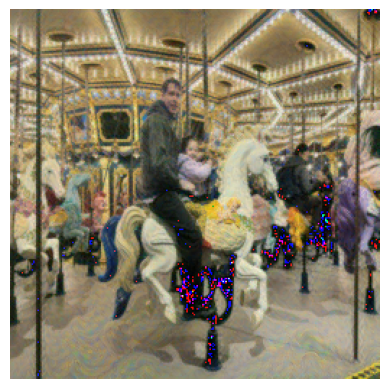

In [36]:
# Test style transfer
content_path = image_path  # Replace with your content image path
style_path = background_path  # Replace with your style image path
output_path = "styled_image.jpg"
style_transfer(content_path, style_path, output_path,iterations=500)
## Content loss (2-5) preserving content image, style loss the lower the style trasnfer (10-100)

In [188]:
original_image = add_elements('styled_image.jpg','Winnie.png',40,160)

In [190]:
# Save or display the output image
cv2.imwrite('styled_with_heart.jpg', original_image)

# Convert to PIL Image for easy viewing
pil_image = Image.open('styled_with_heart.jpg')
pil_image.show()


In [192]:
original_image = add_elements('styled_with_heart.jpg','cute.png',180,150)

In [194]:
# Save or display the output image
cv2.imwrite('updated.jpg', original_image)

# Convert to PIL Image for easy viewing
pil_image = Image.open('updated.jpg')
pil_image.show()

In [196]:
original_image = add_elements('updated.jpg','Pink.png',80,200)

In [198]:
# Save or display the output image
cv2.imwrite('final.jpg', original_image)

# Convert to PIL Image for easy viewing
pil_image = Image.open('final.jpg')
pil_image.show()

In [230]:
model=GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer=GPT2Tokenizer.from_pretrained('gpt2')
# Set the pad token ID to the end-of-sequence token ID
tokenizer.pad_token = tokenizer.eos_token


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [288]:
# Generate a custom message based on the detected emotion
def generate_message(name, emotion):
    # Create a prompt for GPT-2
    prompt = f"Write a heartfelt and romantic Valentine's Day message for {name}, who feels {emotion}. The message should express love, joy, and appreciation, filled with warmth, and a touch of creativity:"
    
    # Tokenize the prompt and create attention mask
    inputs = tokenizer.encode(prompt, return_tensors="pt")
    attention_mask = inputs.ne(tokenizer.pad_token_id).float()  # Create attention mask
    
    # Generate text using GPT-2
    outputs = model.generate(
        inputs,
        attention_mask=attention_mask,  # Pass the attention mask
        max_length=150,  # Limit the length of the message
        num_return_sequences=1,  # Generate only one message
        no_repeat_ngram_size=2,  # Avoid repeating phrases
        top_k=50,  # Limit the vocabulary to the top 50 words
        top_p=0.90,  # Use nucleus sampling for better quality
        temperature=0.9,  # Increase temperature for more creativity
        pad_token_id=tokenizer.eos_token_id# Set pad token ID
    )
    
    # Decode the generated text
    message = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return message

In [291]:
name = "louie"  # Replace with the name 
message = generate_message(name, emotion)
print(f"Generated message: {message}")

Generated message: Write a heartfelt and romantic Valentine's Day message for louie, who feels happy. The message should express love, joy, and appreciation, filled with warmth, and a touch of creativity:

"I love you, my love. I love to be with you. You are my best friend. And I'm so happy to have you around. Thank you for everything you've done for me. It's been a long time since I've had a good time with my family. But I know you're going to love me for it. So, I want to thank you all for your love and support. We're so grateful for all of you who have been so kind to me and for the love that you have given me."



In [434]:
font_path=[f for f in os.listdir(os.getcwd()) if f.endswith('ttf')][0]

In [444]:
# Step 1: Load background image
background_color = (255, 182, 193)  # Light pink background (RGB)
background = Image.new('RGB', (800, 1000), background_color)

# Step 2: Load the styled image
styled_image = Image.open('final.jpg')  # The image with the style transfer
styled_image = styled_image.resize((400, 400))  # Resize to fit in the card

# Step 3: Paste the styled image on the background
background.paste(styled_image, (200, 50))  # Positioning the image on the card

# Step 4: Define the message (split into 3 lines)
line1 = "Dear Louie,"
line2 = "Happy Valentine's Day! Your presence fills my heart with joy."
line3 = "Thank you for being you."
line4 = "Here's to many more moments of happiness and love!"

# Step 5: Set up the drawing context
draw = ImageDraw.Draw(background)
font =ImageFont.truetype(font_path, 20)  # Set font size to 40
text_color = (0, 0, 0)  # Black color for the text

# Step 6: Calculate the position for the text
# Calculate the bounding box (width and height) of each line of text
line1_bbox = draw.textbbox((0, 0), line1, font)
line2_bbox = draw.textbbox((0, 0), line2, font)
line3_bbox = draw.textbbox((0, 0), line3, font)
line4_bbox = draw.textbbox((0, 0), line4, font)


# Extract width and height from the bounding box
line1_width, line1_height = line1_bbox[2] - line1_bbox[0], line1_bbox[3] - line1_bbox[1]
line2_width, line2_height = line2_bbox[2] - line2_bbox[0], line2_bbox[3] - line2_bbox[1]
line3_width, line3_height = line3_bbox[2] - line3_bbox[0], line3_bbox[3] - line3_bbox[1]
line4_width, line4_height = line4_bbox[2] - line4_bbox[0], line4_bbox[3] - line4_bbox[1]


# Total height of the 3 lines
total_text_height = line1_height + line2_height + line3_height + line4_height

# Centering the text vertically and horizontally
width, height = background.size
x_position = (width - max(line1_width, line2_width, line3_width,line4_width)) // 2  # Center horizontally
y_position = (height - total_text_height) // 2  # Center vertically

# Step 7: Add the text to the image (one line at a time)
draw.text((x_position, y_position), line1, fill=text_color, font=font)
draw.text((x_position, y_position + line1_height), line2, fill=text_color, font=font)
draw.text((x_position, y_position + line1_height + line2_height), line3, fill=text_color, font=font)
draw.text((x_position, y_position + line1_height + line2_height+ line3_height), line4, fill=text_color, font=font)

# Step 8: Save and display the final card
background.save('final_valentines_card_centered.jpg')
background.show()


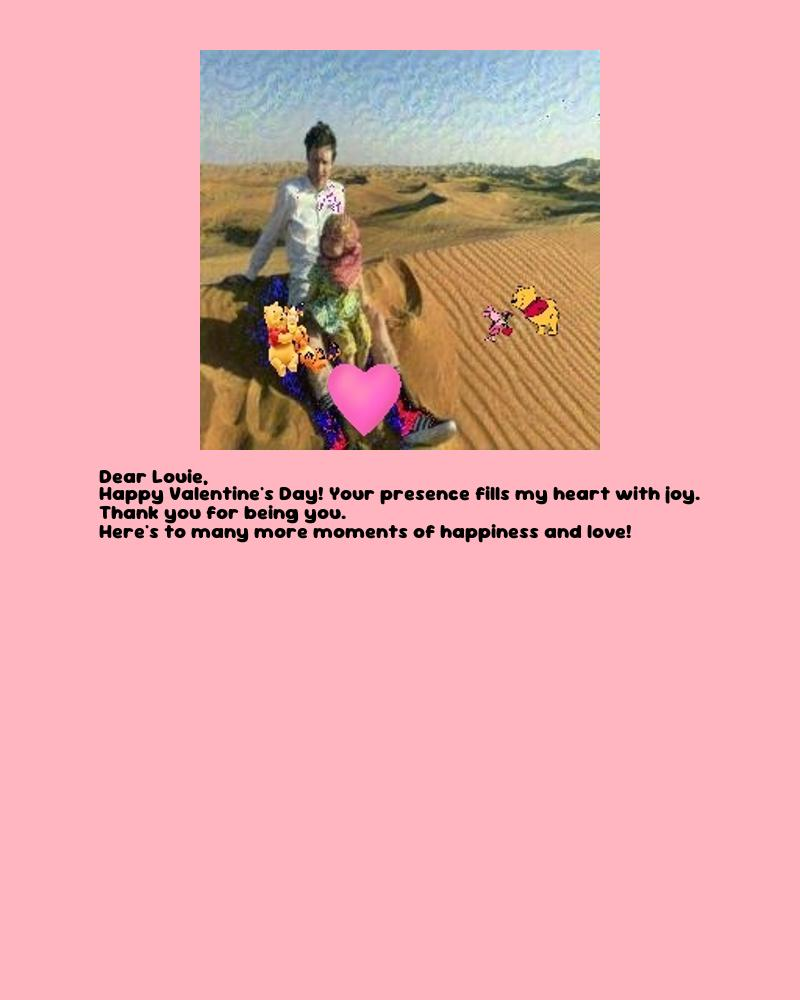

In [448]:
Image.open('final_valentines_card_centered.jpg')